In [1]:
pip install -U -q bitsandbytes datasets transformers peft "transformers[sentencepiece]" 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Block 1: Imports and Configuration ---

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import warnings 
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Transformers and PEFT (for QLoRA)
import transformers
from transformers import (
    AutoModel, 
    AutoTokenizer, 
    BitsAndBytesConfig,
    DataCollatorWithPadding
)
from peft import (
    LoraConfig, 
    get_peft_model, 
    PeftModel
)

# bitsandbytes for 8-bit optimizer
import bitsandbytes as bnb

# Suppress warnings
warnings.filterwarnings("ignore")
torch.cuda.is_available()

True

# Preprocess

In [3]:
#
train = pd.read_csv("/teamspace/studios/this_studio/data/train.csv")
test = pd.read_csv("/teamspace/studios/this_studio/data/test.csv")
sub = pd.read_csv("/teamspace/studios/this_studio/data/sample_submission.csv")

In [4]:
#
train = train[['id'	,'prompt',	'response_a'	,'response_b',	'winner_model_a'	,'winner_model_b',	'winner_tie']] 

In [5]:
train.head()

,id,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [6]:
# remove [''] and creating class 
def preprocess(df, istrain):
    """
    Cleans text columns and creates a 'class' label from winner columns.
    
    Args:
        df (pd.DataFrame): The raw DataFrame with columns like 'prompt', 
                           'winner_model_a', etc.
                           
    Returns:
        pd.DataFrame: A new DataFrame with cleaned text columns and a new 'class' column.
    """
    
    df_processed = df.copy()

    text_cols = ['prompt', 'response_a', 'response_b']
    for col in text_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].str.strip('[]"\'') 

    
    if(istrain):
        
        conditions = [
            (df_processed['winner_model_a'] == 1),
            (df_processed['winner_model_b'] == 1),
            (df_processed['winner_tie'] == 1)
        ]
        
        choices = [0, 1, 2]
        df_processed['class'] = np.select(conditions, choices)
    
    return df_processed

In [ ]:
# 2. Run the preprocessing function
train_pro1 = preprocess(train, True)
test_pro1 = preprocess(test, False)

display(train_pro1.head(2))
display(test_pro1)

,id,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class
0,30192,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,0
1,53567,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,1


,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


In [8]:
# prepro 2
def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True
        
    row['options'] = [f"Prompt: {prompt}\n\nResponse: {response_a}",  # Response from Model A
                      f"Prompt: {prompt}\n\nResponse: {response_b}"  # Response from Model B
                     ]
    return row


train_pro2 = train_pro1.apply(make_pairs, axis=1)
display(train_pro2.head(2)) 

test_pro2 = test_pro1.apply(make_pairs, axis=1)  
display(test_pro2.head(2))  


,id,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class,encode_fail,options
0,30192,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,0,False,[Prompt: Is it morally right to try to have a ...
1,53567,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,1,False,[Prompt: What is the difference between marria...


,id,prompt,response_a,response_b,encode_fail,options
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...,False,"[Prompt: I have three oranges today, I ate an ..."
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...,False,[Prompt: You are a mediator in a heated politi...


In [9]:
#
print(train_pro2.shape, test_pro2.shape)
display(train_pro2['encode_fail'].value_counts())
display(test_pro2['encode_fail'].value_counts())

(57477, 10) (3, 6)


encode_fail
False    57477
Name: count, dtype: int64

encode_fail
False    3
Name: count, dtype: int64

In [10]:
train_pro2[['options', 'class']]

,options,class
0,[Prompt: Is it morally right to try to have a ...,0
1,[Prompt: What is the difference between marria...,1
2,[Prompt: explain function calling. how would y...,2
3,[Prompt: How can I create a test set for a ver...,0
4,[Prompt: What is the best way to travel from T...,1
...,...,...
57472,"[Prompt: A simple mnemonic for \u03c0:\n\""How ...",0
57473,"[Prompt: In python, implement a naive Bayes wi...",0
57474,[Prompt: is it unethical to work on building w...,0
57475,"[Prompt: If a bait contains 0,0025% bromadiolo...",1


# Config

In [11]:
# --- Configuration Class ---
# We store all hyperparameters here
class CFG:
    # Model configuration
    MODEL_PRESET = "/teamspace/studios/this_studio/model" # A strong encoder model
    SEQUENCE_LENGTH = 512 # Max length to pad/truncate to
    
    # QLoRA configuration
    LORA_R = 8           # Rank of the LoRA adapters
    LORA_ALPHA = 16      # Alpha parameter for LoRA scaling
    LORA_DROPOUT = 0.1   # Dropout for LoRA layers
    # Modules to target. This can vary by model. 
    # For DeBERTa-v3, "query_proj", "key_proj", "value_proj", "dense" are common.
    TARGET_MODULES = [
        "query_proj",
        "key_proj",
        "value_proj",
        "dense",
    ]

    # Training configuration
    BATCH_SIZE = 16       # Batch size (keep low for large models)
    EPOCHS = 3           # Number of epochs to train
    LEARNING_RATE = 1e-4 # Learning rate
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Data
    TEST_SPLIT = 0.2     # 20% of data for validation
    RANDOM_SEED = 42     # For reproducible splits

print(f"Imports complete. Using device: {CFG.DEVICE}")

Imports complete. Using device: cuda


# Tokenization


In [12]:
# --- Block 2: Data Loading and Preprocessing ---

train_df, val_df = train_test_split(
    train_pro2, test_size=CFG.TEST_SPLIT, random_state=CFG.RANDOM_SEED, stratify=train_pro2['class']
)

# 3. Convert to Hugging Face Dataset objects
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True))
})

# 4. Load the tokenizer (using the local path)
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_PRESET)

# 5. Define the tokenization function
def tokenize_pairs(examples):
    option_a_texts = [pair[0] for pair in examples["options"]]
    option_b_texts = [pair[1] for pair in examples["options"]]
    tokenized_a = tokenizer(option_a_texts, truncation=True, max_length=CFG.SEQUENCE_LENGTH)
    tokenized_b = tokenizer(option_b_texts, truncation=True, max_length=CFG.SEQUENCE_LENGTH)
    return {
        "input_ids_A": tokenized_a["input_ids"], "attention_mask_A": tokenized_a["attention_mask"],
        "input_ids_B": tokenized_b["input_ids"], "attention_mask_B": tokenized_b["attention_mask"],
        "labels": examples["class"]
    }

# 6. Apply the tokenization to the datasets
tokenized_datasets = raw_datasets.map(
    tokenize_pairs, batched=True, remove_columns=raw_datasets["train"].column_names
)


# 7. *** THIS IS THE FIX: Define a Custom Data Collator ***
class SiameseDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        batch_A = []
        batch_B = []
        labels = []
        for feature in features:
            # Separate the A and B parts for padding
            batch_A.append({"input_ids": feature["input_ids_A"], "attention_mask": feature["attention_mask_A"]})
            batch_B.append({"input_ids": feature["input_ids_B"], "attention_mask": feature["attention_mask_B"]})
            labels.append(feature["labels"])

        # Pad each part independently using the tokenizer's pad method
        padded_A = self.tokenizer.pad(batch_A, padding=True, return_tensors="pt")
        padded_B = self.tokenizer.pad(batch_B, padding=True, return_tensors="pt")

        # Reassemble the final batch with our custom keys
        return {
            "input_ids_A": padded_A["input_ids"],
            "attention_mask_A": padded_A["attention_mask"],
            "input_ids_B": padded_B["input_ids"],
            "attention_mask_B": padded_B["attention_mask"],
            "labels": torch.tensor(labels, dtype=torch.long),
        }

# 8. Create DataLoaders using our custom collator
data_collator = SiameseDataCollator(tokenizer=tokenizer)

train_loader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=CFG.BATCH_SIZE, collate_fn=data_collator
)
val_loader = DataLoader(
    tokenized_datasets["validation"], shuffle=False, batch_size=CFG.BATCH_SIZE, collate_fn=data_collator
)

print("Data preparation complete with custom collator.")
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
# Let's inspect a batch to see the final structure
for batch in train_loader:
    print("\nSample batch keys:", batch.keys())
    print("Shape of input_ids_A:", batch['input_ids_A'].shape)
    print("Shape of labels:", batch['labels'].shape)
    break

Map:   0%|          | 0/45981 [00:00<?, ? examples/s]

Map:   0%|          | 0/11496 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Data preparation complete with custom collator.
Train batches: 2874, Validation batches: 719

Sample batch keys: dict_keys(['input_ids_A', 'attention_mask_A', 'input_ids_B', 'attention_mask_B', 'labels'])
Shape of input_ids_A: torch.Size([16, 512])
Shape of labels: torch.Size([16])


In [13]:
# --- Code to Inspect the DataLoader ---

# 1. Get the first batch from the train_loader
# We use iter() and next() to grab just one batch without a full loop.
first_batch = next(iter(train_loader))

print("--- Inspecting the First Batch from the DataLoader ---")

# 2. Print the keys
# This shows all the different tensors the collator has prepared.
print("\n[1] Keys in the batch dictionary:")
print(first_batch.keys())

# 3. Print the shapes of the tensors
# This is a crucial check. The shape should be [batch_size, sequence_length].
# The sequence_length will vary for each batch because of dynamic padding.
print("\n[2] Shapes of the tensors in the batch:")
for key, value in first_batch.items():
    print(f"  - {key}: {value.shape}")

# 4. Decode the token IDs back to text
# This is the most useful step. It shows you the final text input the model sees,
# including special tokens like [CLS], [SEP], and [PAD].

print("\n[3] Decoding the first example in the batch back to text:")

# Get the token IDs for the first item in the batch (index 0)
input_ids_A_example = first_batch['input_ids_A'][0]
input_ids_B_example = first_batch['input_ids_B'][0]
label_example = first_batch['labels'][0]

# Use the tokenizer to convert IDs back to a readable string
decoded_text_A = tokenizer.decode(input_ids_A_example, skip_special_tokens=False)
decoded_text_B = tokenizer.decode(input_ids_B_example, skip_special_tokens=False)

print("\n--- Decoded Option A ---")
print(decoded_text_A)
print("------------------------")

print("\n--- Decoded Option B ---")
print(decoded_text_B)
print("------------------------")

print(f"\nLabel for this example: {label_example.item()}")

--- Inspecting the First Batch from the DataLoader ---

[1] Keys in the batch dictionary:
dict_keys(['input_ids_A', 'attention_mask_A', 'input_ids_B', 'attention_mask_B', 'labels'])

[2] Shapes of the tensors in the batch:
  - input_ids_A: torch.Size([16, 512])
  - attention_mask_A: torch.Size([16, 512])
  - input_ids_B: torch.Size([16, 512])
  - attention_mask_B: torch.Size([16, 512])
  - labels: torch.Size([16])

[3] Decoding the first example in the batch back to text:

--- Decoded Option A ---
[CLS] Prompt: What is the best way to get over a relationship? Response: The best way to get over a relationship is to take time to heal, both emotionally and physically. Give yourself time to mourn the loss, and don't be afraid to seek help from family and friends. Take up new hobbies, activities, and interests that can help you to focus on something positive. Spend time alone and enjoy the solitude. Finally, be kind to yourself and don't be too hard on yourself during this time.[SEP][PAD][P

# Model

In [14]:
# --- Block 3: Model Definition (Final Correction for Dtype) ---

# 1. Define the QLoRA quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 
)

# 2. Load the base model from the local Kaggle path
base_model = AutoModel.from_pretrained(
    CFG.MODEL_PRESET,
    quantization_config=bnb_config,
    device_map={"": 0} 
)

# 3. Define the LoRA configuration
lora_config = LoraConfig(
    r=CFG.LORA_R,
    lora_alpha=CFG.LORA_ALPHA,
    lora_dropout=CFG.LORA_DROPOUT,
    target_modules=CFG.TARGET_MODULES,
    bias="none",
)

# 4. Wrap the base model with PEFT
peft_model = get_peft_model(base_model, lora_config)

print("PEFT model created. Trainable parameters:")
peft_model.print_trainable_parameters()


# 5. Define our custom Siamese Classifier
class SiameseClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        hidden_size = self.encoder.config.hidden_size
        
        # --- THIS IS THE FINAL FIX ---
        # Instead of hard-coding a dtype, we make the classifier's dtype
        # match the encoder's output dtype. This is more robust.
        self.classifier = nn.Linear(hidden_size * 2, 3).to(encoder.dtype)

    def forward(self, input_ids_A, attention_mask_A, input_ids_B, attention_mask_B):
        outputs_A = self.encoder(
            input_ids=input_ids_A,
            attention_mask=attention_mask_A
        ).last_hidden_state
        
        outputs_B = self.encoder(
            input_ids=input_ids_B,
            attention_mask=attention_mask_B
        ).last_hidden_state

        pooled_A = torch.mean(outputs_A, dim=1) 
        pooled_B = torch.mean(outputs_B, dim=1) 
        
        concat_pooled = torch.cat((pooled_A, pooled_B), dim=1) 
        
        logits = self.classifier(concat_pooled)
        return logits

# 6. Instantiate the final model
model = SiameseClassifier(encoder=peft_model).to(CFG.DEVICE)

print("\nCustom SiameseClassifier model created successfully.")
print(f"Classifier dtype: {model.classifier.weight.dtype}")

PEFT model created. Trainable parameters:
trainable params: 663,552 || all params: 141,967,872 || trainable%: 0.4674

Custom SiameseClassifier model created successfully.
Classifier dtype: torch.float16


In [18]:
# --- Block 4: Training Loop and History Saving ---
from tqdm.notebook import tqdm

# Lists to store metrics from each epoch
train_history = []
val_history = []

# 1. Define Optimizer and Loss Function
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=CFG.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

# --- Training Loop ---
best_val_loss = float('inf')
model.train()

for epoch in range(CFG.EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{CFG.EPOCHS} ---")
    
    # --- Training Phase ---
    train_loss = 0.0
    train_loop = tqdm(train_loader, desc="Training")
    
    for batch in train_loop:
        batch = {k: v.to(CFG.DEVICE) for k, v in batch.items()}
        logits = model(
            input_ids_A=batch["input_ids_A"], attention_mask_A=batch["attention_mask_A"],
            input_ids_B=batch["input_ids_B"], attention_mask_B=batch["attention_mask_B"]
        )
        loss = loss_function(logits, batch["labels"])
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    train_history.append({"epoch": epoch + 1, "loss": avg_train_loss})
    print(f"End of Epoch {epoch + 1} - Average Training Loss: {avg_train_loss:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    val_loop = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for batch in val_loop:
            batch = {k: v.to(CFG.DEVICE) for k, v in batch.items()}
            logits = model(
                input_ids_A=batch["input_ids_A"], attention_mask_A=batch["attention_mask_A"],
                input_ids_B=batch["input_ids_B"], attention_mask_B=batch["attention_mask_B"]
            )
            loss = loss_function(logits, batch["labels"])
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == batch["labels"]).sum().item()
            total_predictions += batch["labels"].size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_predictions
    val_history.append({"epoch": epoch + 1, "loss": avg_val_loss, "accuracy": val_accuracy})
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # --- Save the best model locally ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_path = "/teamspace/studios/this_studio/best_model_checkpoint"
        model.encoder.save_pretrained(save_path)
        print(f"Model improved! Saved checkpoint to: {save_path}")

    model.train()

print("\n--- Training Complete ---")


--- Epoch 1/3 ---


Training:   0%|          | 0/2874 [00:00<?, ?it/s]

End of Epoch 1 - Average Training Loss: 1.0408


Validation:   0%|          | 0/719 [00:00<?, ?it/s]

Validation Loss: 1.0427, Validation Accuracy: 0.4575
Model improved! Saved checkpoint to: /teamspace/studios/this_studio/best_model_checkpoint

--- Epoch 2/3 ---


Training:   0%|          | 0/2874 [00:00<?, ?it/s]

End of Epoch 2 - Average Training Loss: 1.0674


Validation:   0%|          | 0/719 [00:00<?, ?it/s]

Validation Loss: 1.1180, Validation Accuracy: 0.3090

--- Epoch 3/3 ---


Training:   0%|          | 0/2874 [00:00<?, ?it/s]

End of Epoch 3 - Average Training Loss: 1.1097


Validation:   0%|          | 0/719 [00:00<?, ?it/s]

Validation Loss: 1.1064, Validation Accuracy: 0.3090

--- Training Complete ---


--- Final Training and Validation Scores ---


,Train Loss,Validation Loss,Validation Accuracy
epoch,,,
1,1.040838,1.042711,0.457463
2,1.067406,1.117971,0.308977
3,1.109654,1.106409,0.308977


<Axes: ylabel='Accuracy'>

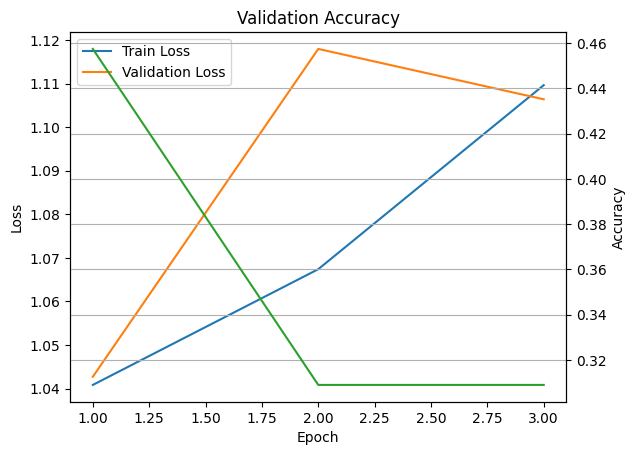

In [19]:
# --- Block 5: Display Training and Validation Scores ---

# 1. Create DataFrames from the history lists
train_history_df = pd.DataFrame(train_history)
val_history_df = pd.DataFrame(val_history)

# 2. Rename columns for clarity
train_history_df = train_history_df.rename(columns={"loss": "Train Loss"})
val_history_df = val_history_df.rename(columns={"loss": "Validation Loss", "accuracy": "Validation Accuracy"})

# 3. Merge the two DataFrames on the 'epoch' column
scores_df = pd.merge(train_history_df, val_history_df, on="epoch")

# 4. Set the 'epoch' column as the index for better readability
scores_df = scores_df.set_index("epoch")

# 5. Display the final scores table
print("--- Final Training and Validation Scores ---")
display(scores_df)

# You can also plot the results
scores_df[['Train Loss', 'Validation Loss']].plot(
    title='Training vs. Validation Loss',
    xlabel='Epoch',
    ylabel='Loss'
)
scores_df['Validation Accuracy'].plot(
    title='Validation Accuracy',
    xlabel='Epoch',
    ylabel='Accuracy',
    secondary_y=True, # Use a secondary y-axis for the accuracy
    grid=True
)

# submission csv


In [22]:
# --- Final Block: Inference and Submission (Corrected for QLoRA) ---
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from peft import PeftModel
from transformers import BitsAndBytesConfig, AutoModel

# --- 1. Define Test-Specific Helper Functions ---
# These are modified versions that DO NOT look for 'labels' or 'class'

def tokenize_pairs_test(examples):
    """Tokenizes pairs for the test set (no labels)."""
    option_a_texts = [pair[0] for pair in examples["options"]]
    option_b_texts = [pair[1] for pair in examples["options"]]
    
    # We assume 'tokenizer' and 'CFG' are defined in previous cells
    tokenized_a = tokenizer(option_a_texts, truncation=True, max_length=CFG.SEQUENCE_LENGTH)
    tokenized_b = tokenizer(option_b_texts, truncation=True, max_length=CFG.SEQUENCE_LENGTH)
    
    return {
        "input_ids_A": tokenized_a["input_ids"], "attention_mask_A": tokenized_a["attention_mask"],
        "input_ids_B": tokenized_b["input_ids"], "attention_mask_B": tokenized_b["attention_mask"],
    }

class SiameseDataCollatorTest:
    """Data collator for the test set (no labels)."""
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        batch_A, batch_B = [], []
        
        for feature in features:
            batch_A.append({"input_ids": feature["input_ids_A"], "attention_mask": feature["attention_mask_A"]})
            batch_B.append({"input_ids": feature["input_ids_B"], "attention_mask": feature["attention_mask_B"]})

        padded_A = self.tokenizer.pad(batch_A, padding=True, return_tensors="pt")
        padded_B = self.tokenizer.pad(batch_B, padding=True, return_tensors="pt")

        return {
            "input_ids_A": padded_A["input_ids"],
            "attention_mask_A": padded_A["attention_mask"],
            "input_ids_B": padded_B["input_ids"],
            "attention_mask_B": padded_B["attention_mask"],
        }

# --- 2. Load the Trained QLoRA Model ---

# Get the device (e.g., "cuda" or "cpu")
device = torch.device(CFG.DEVICE)

# A. Load the base model in 4-bit (same as training)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
base_model = AutoModel.from_pretrained(
    CFG.MODEL_PRESET,
    quantization_config=bnb_config,
    device_map={"": 0} # Critical for QLoRA
)

# B. Load the LoRA adapters from your checkpoint
# This is the key fix: we load the adapters ON TOP of the 4-bit base model
checkpoint_path = "/teamspace/studios/this_studio/best_model_checkpoint"
inference_model = PeftModel.from_pretrained(base_model, checkpoint_path)

# C. Merge the adapter weights for fast inference
inference_model = inference_model.merge_and_unload()

# D. Wrap in our classifier and move the final model to the device
model = SiameseClassifier(encoder=inference_model).to(device)
model.eval() # IMPORTANT: Set to evaluation mode

print("Inference model loaded (QLoRA) and prepared successfully.")

# --- 3. Create DataLoader for the Test Data ---
# (We assume 'test_pro2' DataFrame is already created)
test_dataset = Dataset.from_pandas(test_pro2.reset_index(drop=True))

tokenized_test_dataset = test_dataset.map(
    tokenize_pairs_test, # Use our new test-specific function
    batched=True, 
    remove_columns=test_dataset.column_names
)

test_collator = SiameseDataCollatorTest(tokenizer=tokenizer)
test_loader = DataLoader(
    tokenized_test_dataset,
    shuffle=False,
    batch_size=CFG.BATCH_SIZE * 2, # Use a larger batch size for inference
    collate_fn=test_collator
)

# --- 4. Run Inference to Get Predictions ---
all_predictions = []
test_loop = tqdm(test_loader, desc="Predicting")

with torch.no_grad():
    for batch in test_loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(
            input_ids_A=batch["input_ids_A"], attention_mask_A=batch["attention_mask_A"],
            input_ids_B=batch["input_ids_B"], attention_mask_B=batch["attention_mask_B"]
        )
        probs = F.softmax(logits, dim=1)
        all_predictions.append(probs.cpu().numpy())

predictions_np = np.concatenate(all_predictions)

# --- 5. Create Submission File ---
print("\nFormatting submission file...")

submission_df = pd.DataFrame()
submission_df['id'] = test_pro2['id']
submission_df['winner_model_a'] = predictions_np[:, 0]
submission_df['winner_model_b'] = predictions_np[:, 1]
submission_df['winner_tie']     = predictions_np[:, 2]

submission_df.to_csv("/teamspace/studios/this_studio/submission.csv", index=False)

print("\nSubmission file created successfully!")
print(submission_df.head())

Inference model loaded (QLoRA) and prepared successfully.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Predicting:   0%|          | 0/1 [00:00<?, ?it/s]


Formatting submission file...

Submission file created successfully!
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.319824        0.218140    0.461914
1   211333        0.226562        0.266846    0.506836
2  1233961        0.198120        0.271729    0.530273
